In [1]:
import numpy as np
import sympy as sp
from utils import simulate, phase_portrait, phase_graph
from matplotlib.pyplot import *
rc('text', usetex=True)

from scipy.integrate import odeint

def simulate_controller(f, controller, init_state, t0=0, tf=1, N=2000, size=(6, 4), show_plot=False):
    t = np.linspace(t0, tf, N)  # Create time span
    dT = (tf - t0)/N
    x_sol = []
    u_sol = []
    for x_init in init_state:
        x0 = x_init
        u0 = np.array(controller(x0, 0))

        x_sol_i = np.zeros((N, len(x0)))
        u_sol_i = np.zeros((N, 1))

        for i in range(N):
            time = t[i]
            t_k = np.linspace(time, time+dT, 2)
            u = controller(x0, time)
            x_k = odeint(f, x0, t_k, args = (u,))
            x0 = x_k[-1]
            x_sol_i[i,:] = x0
            u_sol_i[i,:] = u

        x_sol.append(x_sol_i)
        u_sol.append(u_sol_i)

    return x_sol, u_sol, t



## **Fundamentals of Robot Control:**
### **Lecture 6: Uncertainty, Sliding Mode, and Robust Control**

Last time we have studied the model based control methods such as feedback linearization, which provide the great results,
however one should have the particularly precise model to do so. 

Today we will discuss the method that facilitate control design even with imprecise models and presence of disturbances. 

Before we move further let us consider the rotational dynamics under the discontinues control:
\begin{equation*}
 \ddot{\varphi} = u
\end{equation*}

Assume that we apply the switching and rate feedback as follows:
\begin{equation*}
 u = - \text{sign}(k\varphi + \dot{\varphi})
\end{equation*}
<!-- 
Let us draw the phase portrait:
 -->


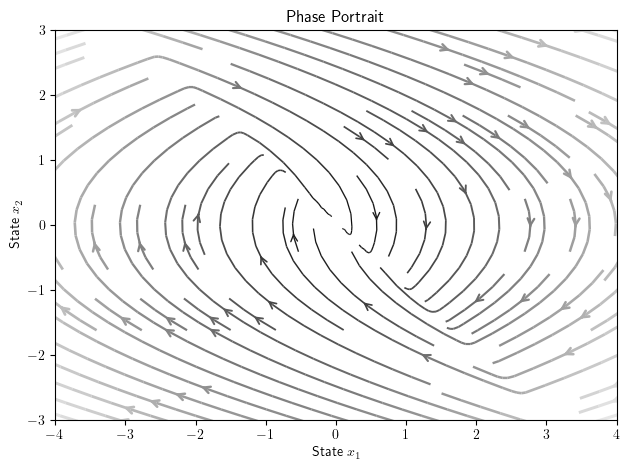

In [2]:
def f(x, t):
    phi = x[0]
    dphi = x[1]
    ddphi = -np.sign(phi + dphi)
    return dphi, ddphi
phase_portrait(f,x_range=[4, 3])


Imaging now somebody have added the disturbance torque $\| \delta(t) \| <\delta_{max}$:
$$
 \ddot{\varphi} = u + \delta(t)
$$
 would you expect for angle to converge yet?

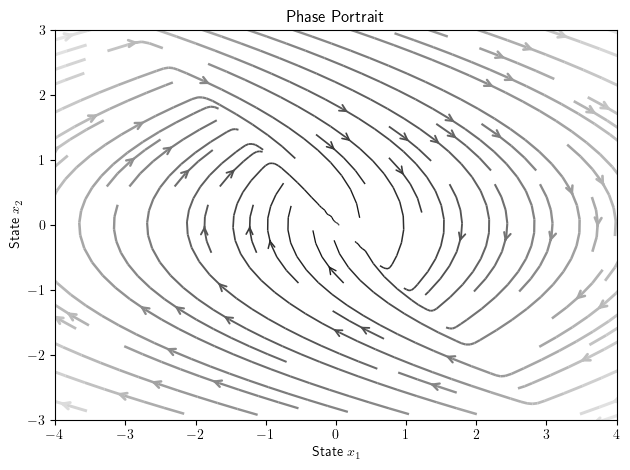

In [11]:
def f(x, t):
    delta = -0.1
    phi = x[0]
    dphi = x[1]
    ddphi = -np.sign(phi + dphi) + delta
    return dphi, ddphi

phase_portrait(f,x_range=[4, 3])

Let us increase $\delta$:

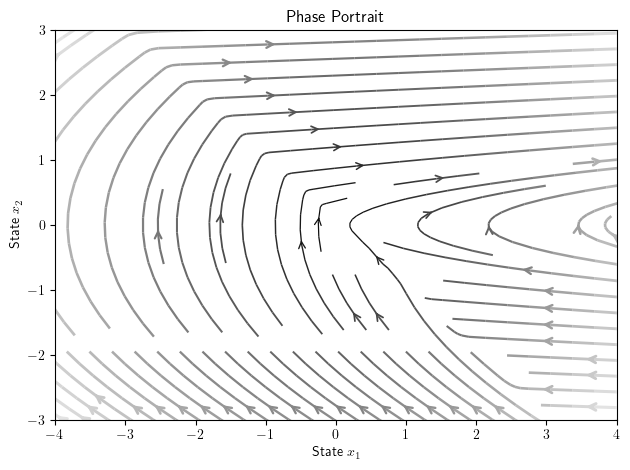

In [26]:
def f(x, t):
    delta = 1.1
    phi = x[0]
    dphi = x[1]
    ddphi = -np.sign(phi + dphi) + delta
    return dphi, ddphi

phase_portrait(f,x_range=[4, 3])

### **Model Uncertainties**

Model imprecision may come from actual uncertainty about the plant (e.g., unknown plant
parameters), or from the purposeful choice of a simplified representation of the
system's dynamics (e.g., modeling friction as linear, or neglecting structural modes in
a reasonably rigid mechanical system). From a control point of view, modeling
inaccuracies can be classified into two major kinds:

* structured (or parametric) uncertainties
* unstructured uncertainties (or unmodeled dynamics)

The first kind corresponds to inaccuracies on the terms actually included in the model,
while the second kind corresponds to inaccuracies on (i.e., underestimation of) the
system order.

As discussed earlier, modeling inaccuracies can have strong adverse effects on
nonlinear control systems. Therefore, any practical design must address them
explicitly. Two major and complementary approaches to dealing with model uncertainty are **robust** and **adaptive** control. Today we are going to discuss the simple approach to robust control, 
so-called sliding control methodology.

### **N-th Order Nonlinear System**

Let us consider the **scalar** system of order $n$ in following form:


$$
\dot{\mathbf{x}} =
\begin{bmatrix}
\dot{x}_1 \\ 
\dot{x}_2 \\ 
\vdots \\ 
\dot{x}_{n} \\ 
\end{bmatrix}
=
\begin{bmatrix}
x_2 \\ 
x_3 \\ 
\vdots \\ 
f(\mathbf{x}) + h(\mathbf{x})u 
\end{bmatrix}
=
\begin{bmatrix}
\dot{y} \\ 
\ddot{y} \\ 
\vdots \\ 
y^{n} \\ 
\end{bmatrix}
=
\begin{bmatrix}
\dot{y} \\ 
\ddot{y} \\ 
\vdots \\ 
f(\mathbf{x}) + h(\mathbf{x})u 
\end{bmatrix}
$$


or compactly:
$$
\dot{x}_{n-1} = y^{n} = f(\mathbf{x}) + h(\mathbf{x})u 
$$


where $\mathbf{x} = [y,\dot{y}, \ddot{y}, \dots, y^{n-1}]^T$ 


A goal is to track the **desired trajectory** given by $y_d$ thus an error is given by:
$$
\tilde{y} = y_d - y
$$
And the whole state **tracking error vector** is given by:
$$
\tilde{\mathbf{x}} = \mathbf{x}_d - \mathbf{x} = [\tilde{y},\dot{\tilde{y}}, \ddot{\tilde{y}}, \dots, \tilde{y}^{n-1}]^T
$$

The goal is to find control law such that $\tilde{y}\rightarrow 0 $ as $t\rightarrow \infty$

As example you may choose any scalar mechanical system:

$$
m(q)\ddot{q} + c(q)\dot{q}^2 + g(q) = b(q)u
$$
where $m(q)>0, b(q) \neq 0 \ \forall q$

Indeed denoting $y = q$ thus $\mathbf{x} = [q, \dot{q}]^T$ and one may represent above as:

$$
\begin{bmatrix}
\dot{y} \\
\ddot{y}
\end{bmatrix}
=
\begin{bmatrix}
\dot{x}_1 \\
\dot{x}_2
\end{bmatrix}
=
\begin{bmatrix}
x_2 \\
-\frac{c(x_1)}{m(x_1)}x^2_2 - \frac{g(x_1)}{m(x_1)} + \frac{b(x_1)}{m(x_1)}u 
\end{bmatrix} = 
\begin{bmatrix}
x_2 \\
f(x_1,x_2) + h(x_1)u 
\end{bmatrix}
$$


### **Sliding Surface**
In some cases, as we have already studied in feedback linearization, it is possible to simplify the control of a high-order nonlinear system, for instance by reducing the order of the system with a carefully chosen composite variable that will fully describe the tracking performance - this is the basic idea of sliding surfaces.

Let us define time-varying surface $\mathcal{S}$ in the the state space $\mathbb{R}^n$ given by scalar equation $s(\mathbf{x}, t)$:
$$
s(\mathbf{x}, t) = s(y, t) = \Big(\frac{d}{dt} + \lambda\Big)^{n-1}\tilde{y}
$$

Applying such transformation yields a new representation of the tracking performance:
$$
s \rightarrow 0   \Rightarrow \tilde{\mathbf{x}} \rightarrow \mathbf{0} \Rightarrow \tilde{y} \rightarrow 0 
$$
Meaning, that the problem of tracking $\mathbf{x}_d$ is equivalent to remaining on the sliding surface


Thus the problem of tracking the $n$-dimensional vector $\mathbf{x}_d$  can in effect be replaced by a $1$ st - order
stabilization problem in $s$. Note that from definition of sliding surface we only need to differentiate s once for the input $u$ to appear.


###  **Sliding Condition**

As one can see once the system is on sliding surface $\mathbf{s}$ the error should eventually converge, the behavior of trajectories on this surface is called **sliding mode**, and is natural to ask what is the condition for sliding mode to appear in other words how to prove convergence to sliding surface?



And one can use Lyapunov-like arguments to do so. Let as define $V = s^2$ as the squared distance to the surface. In order to ensure convergence along all system trajectories one may formulate the following **sliding condition**:

$$
\frac{1}{2}\frac{d}{dt}s^2 \leq -\eta |s|
$$

where $\eta>0$ define the rate of convergence to the sliding surface. 

Satisfying condition or sliding condition, makes the surface an **invariant set** and implies convergence to $\tilde{y}$, since:

$$
(\frac{d}{dt} + \lambda)^{n-1}\tilde{y} = 0
$$

In this sense the surface $s(t)$ is both a place and a dynamics.

### **Convergence Time**

A notable property of the sliding condition is that the surface $s = 0$ will be reached in a
finite time smaller than $s(t=0)/\eta$ 

Indeed integrating the sliding condition (assuming $s>0$) yields:
$$
s(t_f) - s(0) = -s(0) \leq \eta t_f
$$
which implies that $t_f \leq s(0)/\eta$. Repeating the same with $s<0$ yields:
$$
t_f \leq |s(0)|/ \eta
$$

Once sliding surface is reached the transient is then exponential defined by the linear system with time constant $(n-1)/\lambda$. 

Thus two constants $\eta, \lambda$ may be tuned to ensure convergence to specific region $|\tilde{y}|\leq \epsilon$ in **finite predefined time**. 


### **Robust Control via Sliding Mode**

The notable property of the sliding mode based controllers it's ability to withstands the disturbances and uncertainties. Indeed once sliding mode is achived, convergence is didined by the shape of sliding surface and it is free from model uncertainties and disturbances.   

A main idea of the robust control is in designing such control activity $u$ which ensure that tracking error converges even for the uncertain system. 

Given the bounds on uncertainties of dynamics constructing a control law to verify the sliding condition is straightforward. 
Let us illustrate this by following example.


Consider stabilization of second order system:

$$
\ddot{y} + a(t)\dot{y}^2 \cos{3y} = u
$$

with unknown parameter $1 \leq a(t) \leq 2$

Let us define the **nominal dynamics** and **bounds** as follows:

$$
\hat{f}(y,\dot{y}) = -1.5\dot{y}^2 \cos{3y} \quad F(y,\dot{y})  = 0.5\dot{y}^2 |\cos{3y}|
$$

In order to stabilize the system we define the sliding surface:
$$
s(y, t) = \Big(\frac{d}{dt} + \lambda\Big)y = \dot{y} + \lambda y
$$

the time derivative of the sliding surface is the given by:
$$
\dot{s} = 
% f + u - \ddot{y}_d + \lambda \dot{\tilde{y}} = 
-a(t)\dot{y}^2 \cos{3y} + u + \lambda \dot{y}
$$



The best aproximation of a control law that may achive $\dot{s} = 0$ is:
$$
\hat{u} = -\hat{f}+\ddot{y}_d - \lambda \dot{y}
$$

Let us now introduce additional compensation $u_s$ such that $ u = \hat{u} + u_s$ and substitute all to the sliding condition:
$$
\frac{1}{2}\frac{d}{dt}s^2 =\dot{s}s = (f - \hat{f}+ u_s)s = (0.5\dot{y}^2\cos{3y} + u_s)s \leq - \eta |s|
$$


One can choose $u^*$ and $\eta$ such that sliding condition is fulfilled. For instance choose:

$$
    u_s = -k \ \text{sign}(s)
$$

Thus sliding condition become:
$$
\frac{1}{2}\frac{d}{dt}s^2  = (\tilde{f} + k\  \text{sign}(s))s = 0.5\dot{y}^2\cos{3y} \ s + k |s| \leq - \eta |s|
$$

Thus if $k$ is choosen large enough the sliding condition will be always satisfied 


We define controller:

In [21]:
def control(x, t):
    y = x[0]
    dy = x[1]

    # define sliding surface 
    l = 1.
    s = dy + l*y

    k = 10
    u_hat = 1.5 * dy**2 * np.cos(3*y) - l*dy
    u_s = -k*np.sign(s)
 
    return u_hat + u_s


and closed loop dynamics:

In [22]:

def f(x, t):
    y = x[0]
    dy = x[1]
    u = control(x, t)    
    a = 1.2
    ddy = -a* dy**2 * np.cos(3*y) + u 
    return dy, ddy

Let us now draw the phase of closed loop:

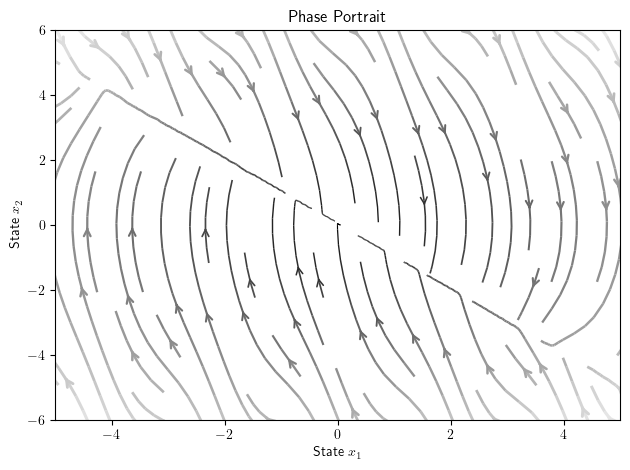

In [23]:
phase_portrait(f,x_range=[5, 6])

Now we can simulate response, using `simulate_controller` routine, but we need to redifine the dynamics:

In [25]:
def f(x, t, u):
    y = x[0]
    dy = x[1]
    a = 1.2
    ddy = -a* dy**2 * np.cos(3*y) + u 
    return dy, ddy

Let us draw the particular trajectory on phase plane:

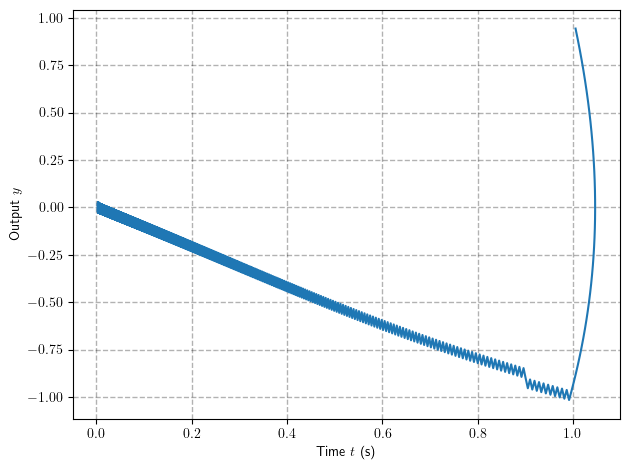

In [26]:
x_sol, u_sol, t = simulate_controller(f, control, [[1, 1]], tf=10, show_plot=True)

for solution in x_sol:
    plot(solution[:,0], solution[:,1])    

ylabel(r'Output $y$')    
xlabel(r'Time $t$ (s)')
grid(color='black', linestyle='--', linewidth=1.0, alpha=0.3)
grid(True)
tight_layout()
show()


### **Methodology of the Robust Control via Sliding Mode**

The methodology of robust control via sliding mode can be formulated in following steps:

1.   Define the **sliding surface** $s(y, t)$
2.   Derive **nominal** control $\hat{u}$ (our best guess) that may achive $\dot{s} = 0$ 
3.   Modify control law by **discontinuse term** that will bring system to **sliding mode** by satisfying the **sliding condition**.



### **Sliding mode for  N-Dimensional Companion Form**


The similarly, if one $n$-dimensional system with uncertainty both in $f$ and $h$. 
$$
y^n = f(y,\dot{y},\dots,y^{n-1}) + h(y,\dot{y},\dots,y^{n-1}))u 
$$

Let us denote $\hat{f}, \hat{h}$ as our best guess for the **nominal model** with estimation errors which is bounded:
$$
| \hat{f}(\mathbf{x}) - f(\mathbf{x}) | = | \tilde{f}(\mathbf{x}) | \leq F(\mathbf{x}, t) \quad | \hat{h}(\mathbf{x}) - h(\mathbf{x}) |  = | \tilde{h}(\mathbf{x}) |\leq H(\mathbf{x},t)
$$



First we choose sliding surface as:
$$
s(y, t) = \Big(\frac{d}{dt} + \lambda\Big)^{n-1}\tilde{y}
$$

And we look for the controller in form:
$$
u = \hat{u} + u_s = \hat{u} + \frac{k}{\hat{h}}\operatorname{sign}(s)
$$

where nominal part $\hat{u}$ given:
$$
\hat{u} = \hat{h}^{-1}(-\hat{f} + \ddot{y}_d  + \lambda \dot{\tilde{y}}) 
$$

The last step is to choose $k$ that will satisfy the sliding condition:
$$
s\tilde{f} + s\tilde{h}\hat{u} + \frac{h}{\hat{h}} k |s| \leq - \eta|s| 
$$

the natural question is then how to choose $k$?


### **Bounds on Sliding Gain**

A large sliding gain will be overly conservative and may lead to  increase in control effort. It is always desirable to estimate the minimal value of $k$ while still ensuring that sliding mode is satisfied:
$$
s\tilde{f} + s\tilde{h}\hat{u} + \frac{h}{\hat{h}} k |s| \leq - \eta |s|\Rightarrow k_{min} \geq \frac{\hat{h}}{h}(\eta + |\tilde{f}| + |\tilde{h}||\hat{u}|)
$$
Thus if one will find the upper and lower bounds of functions $f,h$ as follows:
$$
f_{min}\leq f \leq f_{max}, \quad 0 \leq h_{min} \leq h \leq h_{max}
$$



Letting estimates $\hat{f} = (f_{max} + f_{min})/2$ and $\hat{h} = (h_{max} + h_{min})/2$ one may define the following:
$$
 |\tilde{h}| < H = \frac{1}{2}|h_{max} - h_{min}|, \quad |\tilde{f}| < F =  \frac{1}{2}|f_{max} - f_{min}|
$$

Thus sliding mode condition is satisfied with:
$$
k \geq  \frac{H}{h_{min}}(\eta + F +H|\hat{u}|)
$$


As example let us consider a simplified model of the motion of an underwater vehicle:

$$
m\ddot{y} + b\dot{y}|\dot{y}| + c g = u 
$$

$m$ is the mass of the vehicle (including the so-called added-mass, associated with motion in a fluid), $b$ is a
drag coefficient and $c$ is combined effect of buoyancy and gravity. 

In practice, $m$, $b$, and $c$ are not known accurately, because they only describe
loosely the complex hydrodynamic effects that govern the vehicle's motion.

First we reformulate dynamics as follows:
$$
\ddot{y} = \frac{b}{m}\dot{y}|\dot{y}| - \frac{b}{c}g + \frac{1}{m}u = f(y, \dot{y}) + h(y, \dot{y}) u
$$

In [27]:

def f(x, t, u):
    y = x[0]
    dy = x[1]
    m = 1.2 + 0.5*np.sin(t)
    b = 1.9 + 0.5*np.sin(t)
    c = 5.2 + 0.2*np.sin(t)
    g = 9.81
    
    ddy = (-b*dy * abs(dy) - c*g + u)/m
    return dy, ddy

We consider the tracking of harmonic trajectory $y_d = \sin(t)$:

In [29]:
def trajectory(t):
    y_d = np.sin(t)
    dy_d = np.cos(t)
    ddy_d = -np.sin(t)
    return y_d, dy_d, ddy_d

Let us define sliding mode controller:

In [30]:
g = 9.81
# parameter guess
m_hat = 1
b_hat = 2
c_hat = 5
# contro
L = 1
k = 15
eta = 0.1

def control(x, t):
    y = x[0]
    dy = x[1]
    
    y_d, dy_d, ddy_d = trajectory(t)
    
    y_e = y - y_d
    dy_e = dy - dy_d
    s = dy_e + L*y_e
    
    f_hat = (-b_hat*dy * abs(dy) - c_hat*g)/m_hat
    h_hat = 1/m_hat
    u_hat = (ddy_d + L*dy_e - f_hat)/h_hat  
    u_s = -k*np.sign(s)/h_hat
    # u_s = -k*s/h_hat

    return u_hat + u_s


We simulate the response:

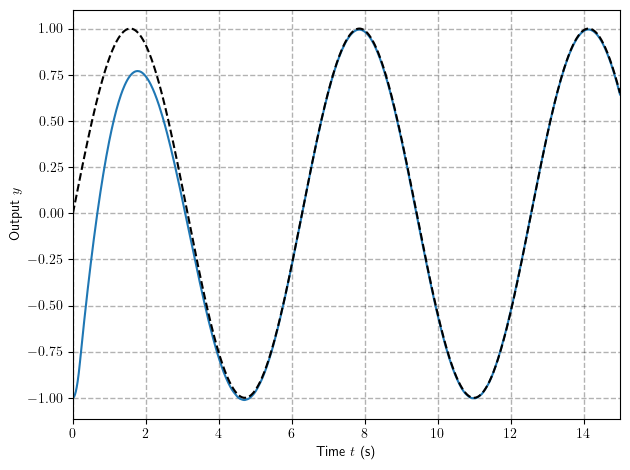

In [31]:
x_sol, u_sol, t = simulate_controller(f, control, [[-1.0, 0]], tf=15, show_plot=True, N = 5000)
y_d, dy_d, _ = trajectory(t)
y, dy = x_sol[0][:,0], x_sol[0][:,1]

plot(t, y)    
plot(t, y_d,color = 'black', linestyle='--' )
xlim([t[0],t[-1]])
ylabel(r'Output $y$')    
xlabel(r'Time $t$ (s)')
grid(color='black', linestyle='--', linewidth=1.0, alpha=0.3)
grid(True)
tight_layout()
show()


### **Chattering**

In order to account for the presence of modeling imprecision and of disturbances, the control law has to be discontinuous across $s(t)$. 
Since the implementation of the associated control switchings is necessarily imperfect (for
instance, in practice switching is not instantaneous, and the value of $s$ is not known
with infinite precision), this leads to chattering. 

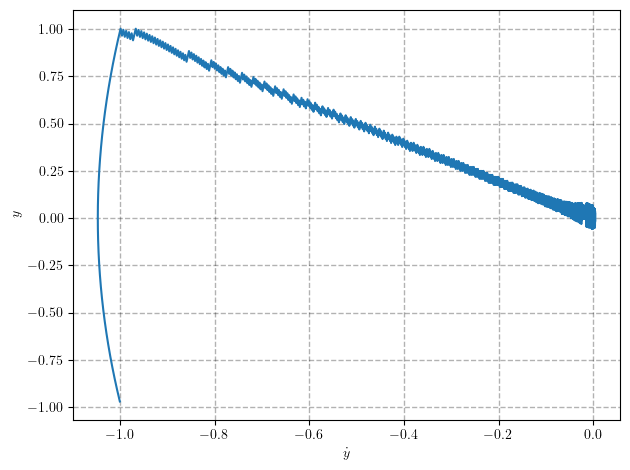

In [36]:
plot(y - y_d, dy - dy_d)    
ylabel(r'$y$')    
xlabel(r'$\dot{y}$')
grid(color='black', linestyle='--', linewidth=1.0, alpha=0.3)
grid(True)
tight_layout()
show()

The controller effort:

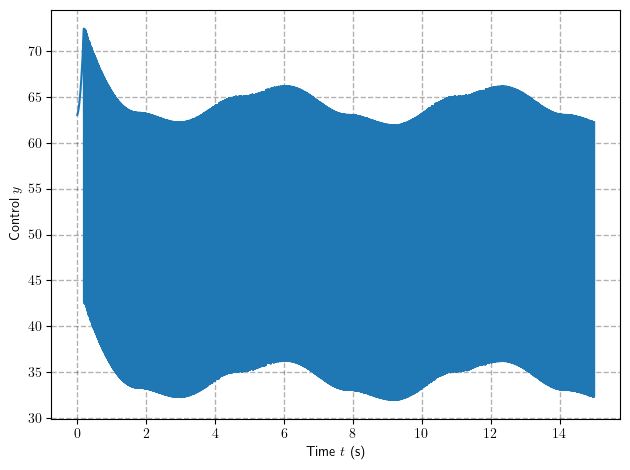

In [37]:
plot(t, u_sol[0])    
ylabel(r'Control $y$')    
xlabel(r'Time $t$ (s)')
grid(color='black', linestyle='--', linewidth=1.0, alpha=0.3)
grid(True)
tight_layout()
show()

Chattering is undesirable in practice (with a few exceptions), since it involves high control activity and further may excite high-
frequency dynamics neglected in the course of modeling (such as unmodeled structural modes, neglected time-delays, and so on). 

Thus, in a second step detailed in the discontinuous control law u is suitably smoothed to achieve an optimal
trade-off between control bandwidth and tracking precision.

### **Continuous Approximations of Switching Control Laws**

In general, chattering must be eliminated for the controller to perform properly. This
can be achieved by smoothing out the control discontinuity in a thin **boundary layer**
neighboring the switching surface:

$$
\mathcal{B}(t) = \{ \mathbf{x} :|s(\mathbf{x}, t)|\leq \Phi \}, \quad \Phi>0
$$

where $\Phi$ is a thickness of boundary layer.

This is usually done by approximating the discontinues $\text{sign}(s)$ function with saturation $\text{sat}(s/\Phi)$.

Let us use this idea to modify the proposed controller:

In [34]:
Phi = 0.05
    
def control(x, t):
    y = x[0]
    dy = x[1]
    # print(t)
    y_d, dy_d, ddy_d = trajectory(t)
    # y_d, dy_d, ddy_d = 0, 0, 0

    y_e =  y - y_d
    dy_e = dy - dy_d

    s = dy_e + L*y_e
    
    f_hat = (-b_hat*dy * abs(dy) - c_hat*g)/m_hat
    h_hat = 1/m_hat
    
    u_hat = (ddy_d + L*dy_e - f_hat)/h_hat  

    if abs(s) > Phi:
        u_s = -k*m_hat*np.sign(s)
    else:
        u_s = -k*m_hat*s/Phi
        
    return u_hat + u_s

And let's simulate response of "smoothed" controller:

In [35]:
x_sol_s, u_sol_s, t = simulate_controller(f, control, [[-1, 0]], tf=15, show_plot=True, N = 5000)
y_s, dy_s = x_sol_s[0][:, 0], x_sol_s[0][:, 1]

Now we can compare the behavior of the controller defined above with its approximated version:

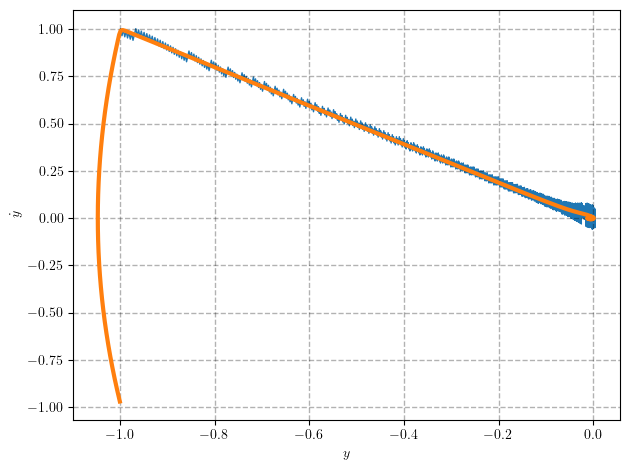

In [42]:
plot(y-y_d, dy - dy_d, linewidth=1.0, zorder = -4)
plot(y_s-y_d, dy_s-dy_d, linewidth=3.0)
xlabel(r'$y$')
ylabel(r'$\dot{y}$')
grid(color='black', linestyle='--', linewidth=1.0, alpha=0.3)
grid(True)
tight_layout()
show()


The input signal is succesfully smoothed:

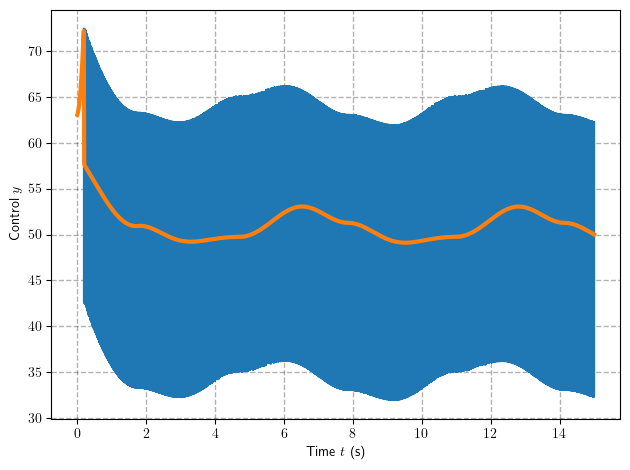

In [43]:
plot(t, u_sol[0])
plot(t, u_sol_s[0], linewidth=3.0)
ylabel(r'Control $y$')
xlabel(r'Time $t$ (s)')
grid(color='black', linestyle='--', linewidth=1.0, alpha=0.3)
grid(True)
tight_layout()
show()

And tracking errors are almost the same:

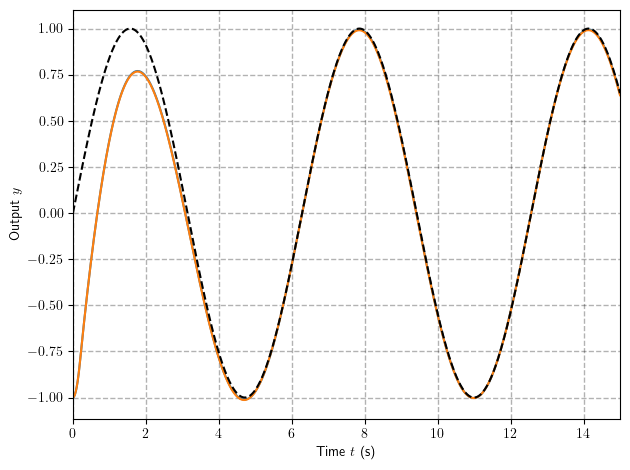

In [44]:
plot(t, y) 
plot(t, y_s) 
plot(t, y_d,color = 'black', linestyle='--' )
xlim([t[0],t[-1]])
ylabel(r'Output $y$')    
xlabel(r'Time $t$ (s)')
grid(color='black', linestyle='--', linewidth=1.0, alpha=0.3)
grid(True)
tight_layout()
show()


The aproximated variant of the controller guaranty that the boundary layer is attractive and invariant: all trajectories starting inside $\mathcal{B}(t=0)$
remain inside $\mathcal{B}(t)$ for all $t>0$. this leads to tracking to within a guaranteed
precision $\epsilon$ (rather than "perfect" tracking), and one can specifically find the particular bounds on trajectories as:

$$
|\tilde{y}^{(i)}| \leq (2\lambda)^i \epsilon
$$
with $\epsilon = \Phi/\lambda^{n-1}$. 

This fact together with finite time convergence allow one to build the practical control systems with predefined precision and transient time. 

### **Robust Inverse Dynamics over Mechanical System via Sliding Mode Control**



We have shown how to design the sliding mode robust controllers for the special type of scalar systems, however in most cases our robotic systems are represented as system of second order equations. For instance let us consider mechanical system in familiar form:

$$
\mathbf{M}(\mathbf{q})\ddot{\mathbf{q}} + \mathbf{c}(\mathbf{q},\dot{\mathbf{q}}) + \mathbf{g}(\mathbf{q}) + \delta(\mathbf{q}, \dot{\mathbf{q}}, t) = \mathbf{u}
$$

However now we assume that dynamics is not completely known, as well as there is some disturbance term $\delta$

Recalling inverse dynamics approach we can apply the following outer loop controller to partially linearize our system given the estimates of model $\hat{(\cdot)}$:

$$
\mathbf{u} = \hat{\mathbf{M}}(\mathbf{q})\mathbf{v} + \hat{\mathbf{c}}(\mathbf{q},\dot{\mathbf{q}}) + \hat{\mathbf{g}}(\mathbf{q})
$$

Substitution to the dynamics yields:

$$
    \ddot{\mathbf{q}} = \mathbf{f}(\mathbf{q},\dot{\mathbf{q}}) + \mathbf{B}(\mathbf{q})\mathbf{v}
$$

where $\mathbf{f} = \mathbf{M}^{-1}(\tilde{\mathbf{c}} + \tilde{\mathbf{g}} + \delta)$ and $\mathbf{B} = \mathbf{M}^{-1}\hat{\mathbf{M}}$

Now we can apply the sliding mode technique! 

**Sliding surface**

To do so we now consider $n$ dimensional sliding surfaces given by:

$$
\mathbf{s} = \dot{\tilde{\mathbf{q}}} + \Lambda \tilde{\mathbf{q}}
$$

with $\Lambda$ being p.d. matrix.

**Approximate controller**

First let us define the controller as sliding feedforward with additional robustyfing part to be choosen: 
$$
    \mathbf{v} = \mathbf{v}_s + \mathbf{v}_n =\mathbf{v}_s + \ddot{\mathbf{q}}_d + \mathbf{\Lambda}\dot{\tilde{\mathbf{q}}}
$$

**Sliding condition**

Now we are ready to define sliding condition:

$$
\frac{1}{2}\frac{d}{dt}\|\mathbf{s}\|^2 = \mathbf{s}^T\dot{\mathbf{s}}< \eta \|\mathbf{s}\|
$$



The time derivative of $\mathbf{s}$ is connected to dynamics as follows:
$$
\dot{\mathbf{s}} = \ddot{\tilde{\mathbf{q}}} + \Lambda \dot{\tilde{\mathbf{q}}} = \mathbf{v}_n - \ddot{\mathbf{q}} = \mathbf{v}_n - \mathbf{f} - \mathbf{B}(\mathbf{v}_n + \mathbf{v}_s) = \mathbf{w} - \mathbf{B}\mathbf{v}_s 
$$
with $\mathbf{w} = (\mathbf{I} - \mathbf{B})\mathbf{v}_n -\mathbf{f} $

Substitution to sliding condition yields:

$$
 \mathbf{s}^T\mathbf{w} - \mathbf{s}^T\mathbf{B}\mathbf{v}_s  \leq \|\mathbf{s}\|\|\mathbf{w}\| - \mathbf{s}^T\mathbf{B}\mathbf{v}_s  \leq - \eta \|\mathbf{s}\|
$$

**Robust Controller**


Thus we can choose the $\mathbf{v}$ as:
$$
    \mathbf{v}_s = \frac{k}{\sigma_{max}}\hat{\mathbf{M}}^{-1}\frac{\mathbf{s}}{\|\mathbf{s}\|} = \rho \frac{\mathbf{s}}{\|\mathbf{s}\|} 
$$

where $\sigma_{max}$ is maximal singuilar value of $M^{-1}$


which provide:
$$
    \|\mathbf{s}\|\|\mathbf{w}\| - \mathbf{s}^T\mathbf{B}\mathbf{v}_s \leq \|\mathbf{s}\|\|\mathbf{w}\| + \frac{k}{\lambda^2_{max}\|\mathbf{s}\|}\mathbf{s}^T\mathbf{M}^{-1}\mathbf{s} \leq \|\mathbf{s}\|\|\mathbf{w}\| + k \|\mathbf{s}\| < - \eta \|\mathbf{s}\|
$$

Setting gain $k$ accordingly to:

$$
    k > \|w\| + \eta
$$

will satisfy sliding conditions.


The resulting controller is then given as follows:
$$
\begin{cases}
\mathbf{u} = \hat{\mathbf{M}}(\mathbf{q})\mathbf{v} + \hat{\mathbf{c}}(\mathbf{q},\dot{\mathbf{q}}) + \hat{\mathbf{g}}(\mathbf{q}) \\
\mathbf{v} = \ddot{\mathbf{q}}_d + \mathbf{\Lambda}\dot{\tilde{\mathbf{q}}} + \mathbf{v}_s \\
\mathbf{v}_s = \rho \frac{\mathbf{s}}{\|\mathbf{s}\|} \\
\mathbf{s} = \dot{\tilde{\mathbf{q}}} + \Lambda \tilde{\mathbf{q}}
\end{cases}
$$


In practice the controller above is effectively smoothed using saturation like function:
$$
\mathbf{v}_s = 
\begin{cases}
\rho \frac{\mathbf{s}}{\|\mathbf{s}\|}, \quad \|\mathbf{s}\| >\epsilon\\
\rho \frac{\mathbf{s}}{\epsilon}, \quad \|\mathbf{s}\| \leq\epsilon
\end{cases}
$$
